# <center>UE 4.1 - Machine Learning </center>

UE 4.1 Machine Learning
Noms et prénoms : GETA Rayane, AZOU Raphaël


In [1]:
import numpy as np
import sklearn as sk
import os
import cv2
from matplotlib import pyplot as plt
import skimage
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float
from sklearn.neighbors import KNeighborsClassifier
import random

path = "./images_ISAR"

---

## Partie I - Analyse de données ISAR

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Généralités sur la base de données</h3>

#### Lecture du fichier
Premièrement, on load le fichier zip contenant les images.

> Nombres d'images : 810
> Taille d'une image : (256, 256)


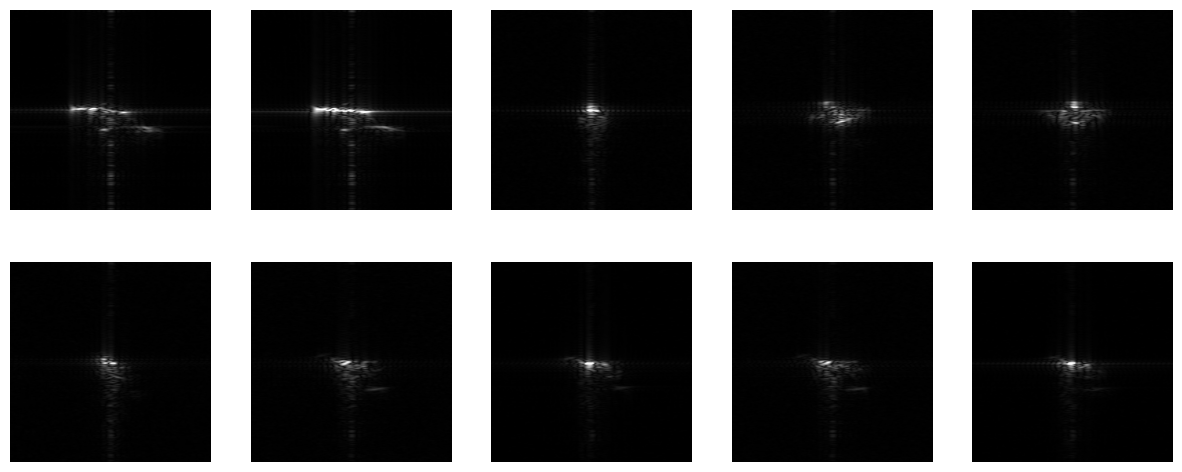

In [2]:
images = []
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

print("> Nombres d'images : "+ str(len(images)))
print("> Taille d'une image : "+ str(images[0].shape))

##Afficage de 10 d'entre elles
plt.subplots(2,5,figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')    
plt.show()

Il y a 810 images dans le dossier "images_ISAR".

#### Séparation des images par classes

In [3]:
# Store the image file names in a list as long as they are bmps
nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
type_appareil=[]
for k in nom_images:
    type_appareil.append(k.split("_")[0])  #split the names before the _

#print(type_appareil)
values, counts = np.unique(type_appareil, return_counts=True)  #count the number of different elements in the list

print("Classes :", values)
print("Nombre d'images par classe :", counts)


Classes : ['A10' 'F14' 'F15' 'F16' 'F4']
Nombre d'images par classe : [162 162 162 162 162]


#### Histogramme

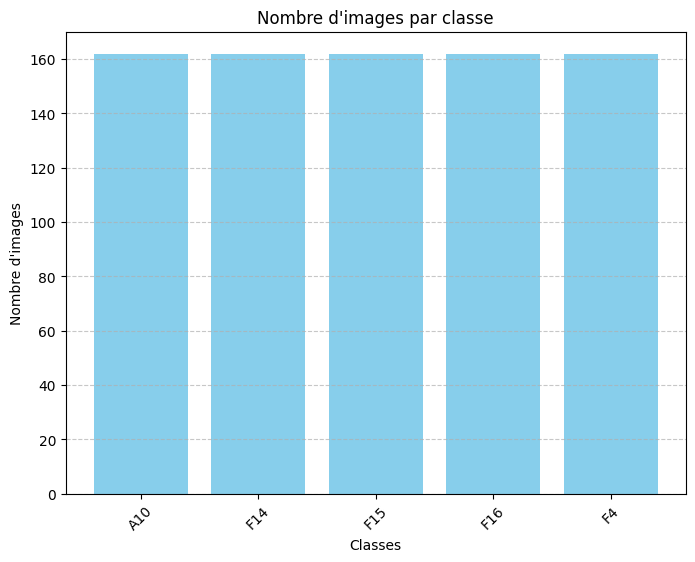

In [4]:

plt.figure(figsize=(8, 6))
plt.bar(values, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout de grilles pour une meilleure lisibilité
plt.show()

### Analyse
On constate que chaque classe contient le même nombre d'images, soit 162. Cela signifie que la base de données est équilibrée et qu'il n'y a pas de biais dans les données. Le modèle ne sera donc pas influencé par une classe plus représentée que les autres.



#### Dimension de l'espace de données

In [5]:
# a completer
print("> Dimension de l'espace de données : ",images[0].shape[0]*images[0].shape[1])
print("> Valeur maximale de l'espace de données : ",np.max(images[0]))
print("> Valeur minimale de l'espace de données : ",np.min(images[0]))

> Dimension de l'espace de données :  65536
> Valeur maximale de l'espace de données :  255
> Valeur minimale de l'espace de données :  0


### Commentaires 
Chaque image a une dimension de 256*256 pixels, soit 65536 pixels par image. Le modèle KPPV peut être lent et coûteux en calcul, car il doit stocker et comparer toutes les données d’entraînement pour chaque prédiction. Cela signifie qu'il n’est pas idéal pour les ensembles de données de grande taille. Il est donc dans notre intérêt de réduire la dimension de l'espace de données pour accélérer le processus de prédiction étant donné que pour les images que nous avons, les zones ayant le plus d'informations sont les zones centrales.

#### Réduction de la dimension des données



##### Affichage des niveaux de gris d'une image aléatoire

> Dimension de l'espace de données après réduction :  22500


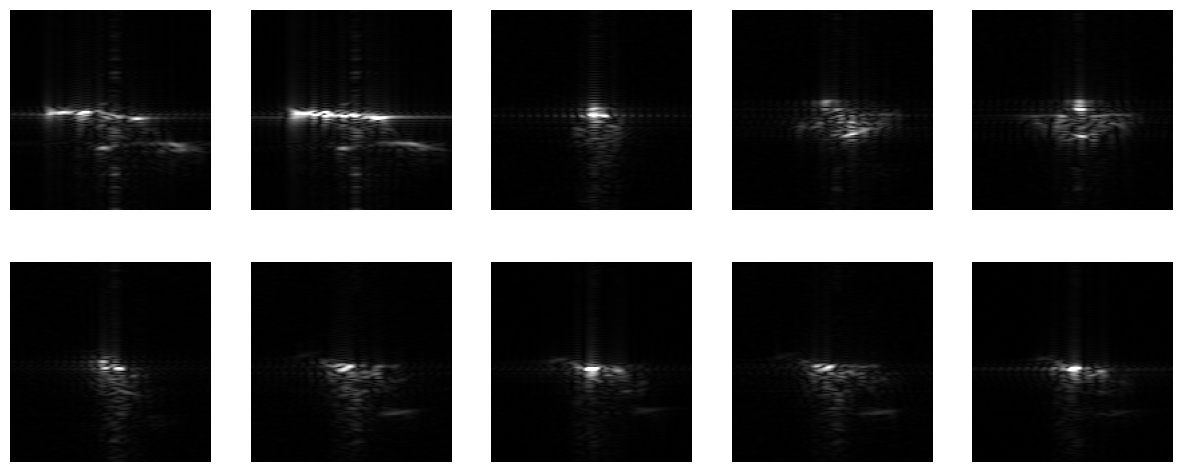

In [6]:
# Crop d'une image [256,256] -> [150,150]
def crop(a):
    new=[]
    for i in range(len(a)):
        new.append(a[i][50:200,50:200])
    return new

def aff_grey(a):
    plt.imshow(a,cmap='gray')
    
cropped_images = crop(images)

plt.subplots(2,5,figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    aff_grey(cropped_images[i])
    plt.axis('off')
    
print("> Dimension de l'espace de données après réduction : ",cropped_images[0].shape[0]*cropped_images[0].shape[1])




Voici quelques images "croppées".

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Load BDD</h3>

Ici, on a une fonction qui à partir d'un dossier donné d'images (de format .bmp) renvoie la matrice des donneés et le vecteur des labels

In [7]:
import cv2
import os
import numpy as np

def load_bdd(directory):
    images = []  # Matrice de données (images mises à plat)
    label_list = []  # Vecteur des classes (labels)
    
    nom_images = [f for f in os.listdir(directory) if os.path.splitext(f)[-1] == '.bmp']
    
    labels = []
    for k in nom_images:
        labels.append(k.split("_")[0])
    
    for filename in nom_images:
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            # Charger l'image en utilisant OpenCV
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Charger l'image en niveau de gris
            if img is not None:
                images.append(img)
                label = filename.split("_")[0]
                label_list.append(label)
    
    # Convertir les listes en tableaux numpy pour la manipulation plus facile
    data = np.array(crop(images))
    label_list = np.array(label_list)
    
    return data, label_list

directory = "./images_ISAR"
data, label = load_bdd(directory)
print("Matrice de données :", data.shape)
print("Vecteur des classes (labels) :", label.shape)




Matrice de données : (810, 150, 150)
Vecteur des classes (labels) : (810,)


## Partie II - Extraction des caractéristiques discriminantes – Image polaire

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Fonction polaire()</h3>

Dimension de l'espace de données avant transformation polaire :  65536
Dimension de l'espace de données après transformation polaire :  2500


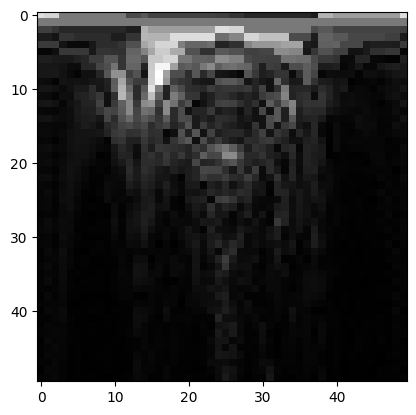

In [8]:
#Image aléatoire

image = random.choice(images)

# exemple de la fonction polaire
def polaire(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]

    return polar_image

# A compléter

polaire_image = polaire(image)
plt.imshow(polaire_image, cmap='gray')
print("Dimension de l'espace de données avant transformation polaire : ",image.shape[0]*image.shape[1])
print("Dimension de l'espace de données après transformation polaire : ",polaire_image.shape[0]*polaire_image.shape[1])

#### Commentaires
La représentation des images en coordonnées polaires permet de mettre en évidence les caractéristiques de l'image en réduisant davantage la dimension de l'espace de données.

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Invariances des images polaires</h3>

### Invariance par rotation

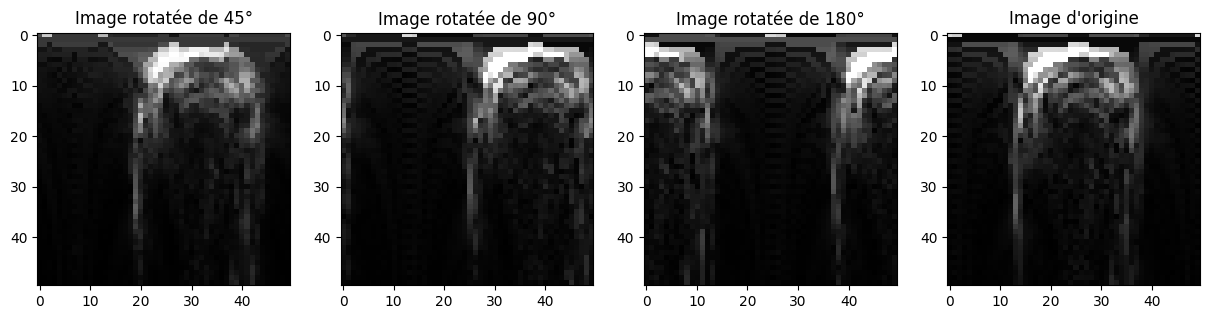

In [9]:
#
# Supposons que 'image' soit votre image d'origine
image = random.choice(images)

def rotate_image_polar(image, angle):
    image_rotated = rotate(image, angle) 
    image_polar = polaire(image_rotated)
    return image_polar

image_rot_45 = rotate_image_polar(image, 45) 
image_rot_90 = rotate_image_polar(image, 90)
image_rot_180 = rotate_image_polar(image, 180)

plt.subplots(1,4,figsize=(15,6))
plt.subplot(1,4,1)
plt.imshow(image_rot_45, cmap='gray')
plt.title("Image rotatée de 45°")
plt.subplot(1,4,2)
plt.imshow(image_rot_90, cmap='gray')
plt.title("Image rotatée de 90°")
plt.subplot(1,4,3)
plt.imshow(image_rot_180, cmap='gray')
plt.title("Image rotatée de 180°")
plt.subplot(1,4,4)
plt.imshow(polaire(image), cmap='gray')
plt.title("Image d'origine")
plt.show()

### Commentaires
On constate que les images polaires ne sont pas invariantes par rotation.

### Invariance par changement d'échelle

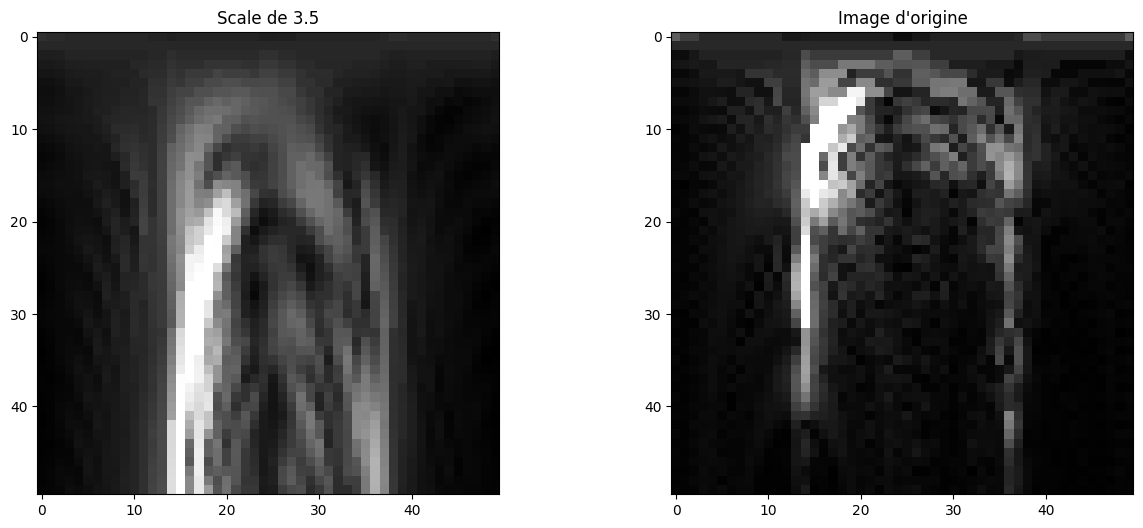

In [23]:
#Changement d'échelle: scale = 3.5
#
# Supposons que 'image' soit votre image d'origine
image = random.choice(images)


def scale_image_polar(image, scale):
    #image_scaled = cv2.resize(image, (0,0), fx=scale, fy=scale)
    image_scaled = rescale(image, scale)
    image_polar = polaire(image_scaled, Nr=50, Mtheta=50, Rmax=50)
    return image_polar

image_scale_3_5 = scale_image_polar(image, 3.5)


plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(image_scale_3_5, cmap='gray')
plt.title("Scale de 3.5")
plt.subplot(1,2,2)
plt.imshow(polaire(image), cmap='gray')
plt.title("Image d'origine")
plt.show()



#### Commentaire
On constate que l'image polaire tirée n'est invariante par changement d'échelle.

### Invariance par changement d'échelle et rotation

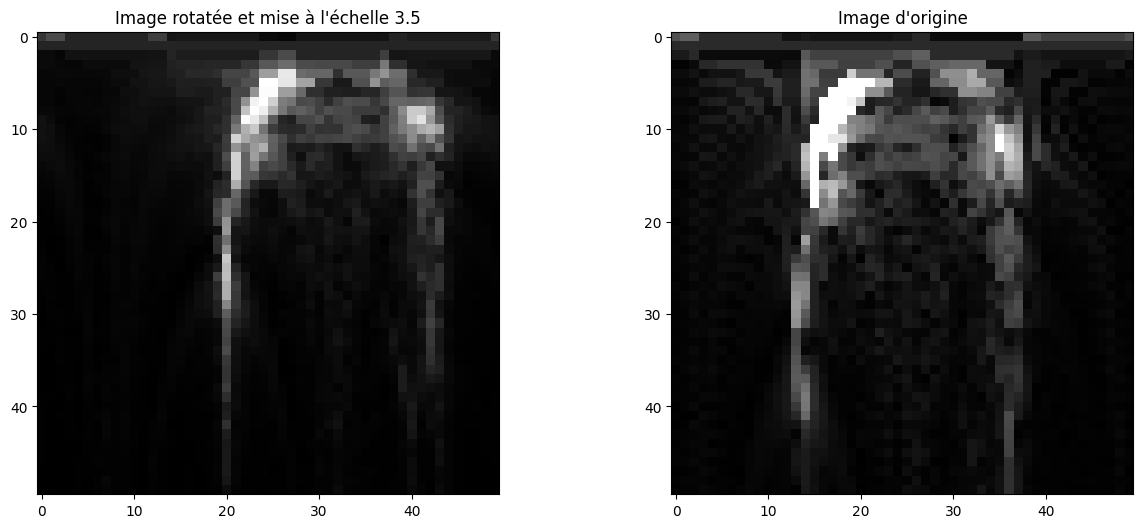

In [11]:
#Changement d'échelle: scale = 3.5

image = random.choice(images)

image_rotated = rotate(image, 45)
image_rotated_scaled = scale_image_polar(image_rotated, 1/np.sqrt(2))

plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(image_rotated_scaled, cmap='gray')
plt.title("Image rotatée et mise à l'échelle 3.5")
plt.subplot(1,2,2)
plt.imshow(polaire(image), cmap='gray')
plt.title("Image d'origine")
plt.show()

L'image obtenue est de taille (50x50).

Question 3 - Nouveau vecteurs caractéristiques: $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$

In [12]:
# exemple de la fonction polaire
def polaire1(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]
    # Moyenne 
    Itheta = np.mean(polar_image, axis=0)
    Ir = np.mean(polar_image, axis=1)
    return polar_image, Itheta, Ir


Commençons pas regarder le résultats des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sur un image aléatoire.

Vecteur Ir :  (50,)
Vecteur Itheta :  (50,)


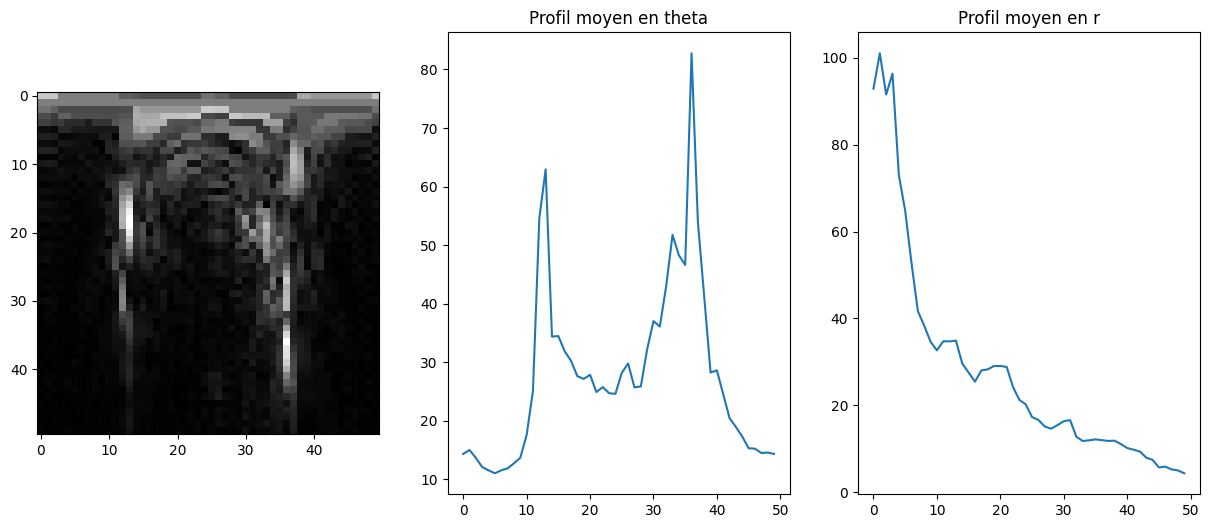

In [13]:
image = random.choice(images)
polar_image, Itheta, Ir = polaire1(image)

print("Vecteur Ir : ", Ir.shape)
print("Vecteur Itheta : ", Itheta.shape)
plt.subplots(1,3,figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(polar_image, cmap='gray')
plt.subplot(1,3,2)
plt.plot(Itheta)
plt.title("Profil moyen en theta")
plt.subplot(1,3,3)
plt.plot(Ir)
plt.title("Profil moyen en r")
plt.show()

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Invariances des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$</h3>

### Invariance par rotation et changement d'échelle

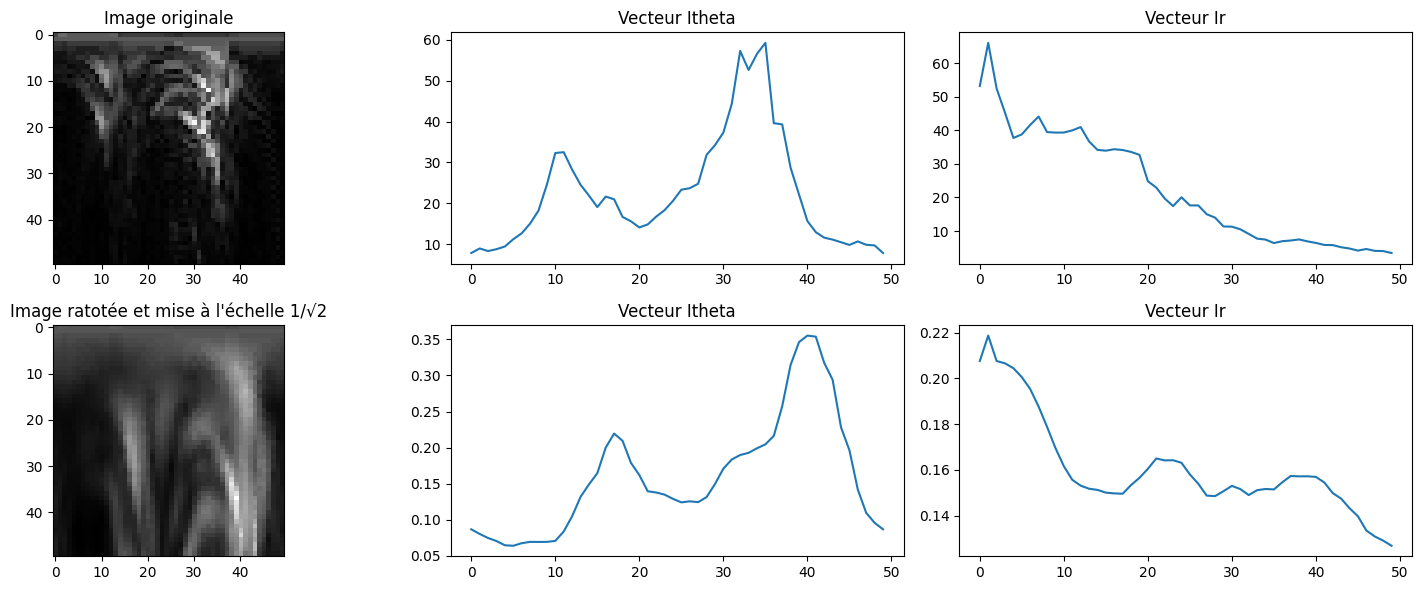

In [14]:
#Changement d'échelle: scale = 3.5
image = random.choice(images)

original_polar, Itheta_original, Ir_original = polaire1(image)

def scale_image_polar_1(image, scale):
    image_scaled = cv2.resize(image, (0,0), fx=scale, fy=scale)
    image_polar, Itheta,Ir = polaire1(image_scaled)
    return image_polar, Itheta, Ir

#image_rotated = rotate_image_polar_1(image, 45)
image_rotated = rotate(image, 45)
image_scaled_rotated, Itheta ,Ir= scale_image_polar_1(image_rotated, 3.5)

# Création des sous-graphiques avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Affichage de l'image originale et ses vecteurs
axes[0, 0].imshow(original_polar, cmap='gray')
axes[0, 0].set_title("Image originale")
axes[0, 1].plot(Itheta_original)
axes[0, 1].set_title("Vecteur Itheta")
axes[0, 2].plot(Ir_original)
axes[0, 2].set_title("Vecteur Ir")

# Affichage de l'image transformée et ses vecteurs
axes[1, 0].imshow(image_scaled_rotated, cmap='gray')
axes[1, 0].set_title("Image ratotée et mise à l'échelle 1/√2")
axes[1, 1].plot(Itheta)
axes[1, 1].set_title("Vecteur Itheta")
axes[1, 2].plot(Ir)
axes[1, 2].set_title("Vecteur Ir")



plt.tight_layout()
plt.show()




On observe que les vecteurs $\mathbf{I}_{\text{θ}}$ et $\mathbf{I}_{\text{r}}$ sont les mêmes après les transformation mais ils ont été translatés. Pour garantir une invariance à la translation, on pourrait utiliser la corrélation de phase pour obten


### Mesure de distances eucliennes

In [15]:
# Distance euclidienne
image = random.choice(images)

image_rotated = rotate(image, 45, resize=False)
image_rotated_polar, Itheta_rotated, Ir_rotated = polaire1(image_rotated)

image_polar, Itheta, Ir = polaire1(image)
    
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)
    
    
# Calcul des distances pour les vecteurs Ir et Itheta
distance_Itheta = euclidean_distance(Itheta, Itheta_rotated)

distance_Ir = euclidean_distance(Ir, Ir_rotated)

# Calcul des distances pour les images polaires
distance_image_polar = euclidean_distance(image_polar, image_rotated_polar)

print("Distance entre les vecteurs Itheta : ", distance_Itheta)
print("Distance entre les vecteurs Ir : ", distance_Ir)
print("Distance entre les images polaires : ", distance_image_polar)


Distance entre les vecteurs Itheta :  191.81922774656758
Distance entre les vecteurs Ir :  236.68484246147761
Distance entre les images polaires :  2037.8249093191334


#### Cross-correlation pour la rotation

Pour une multitude d'angle, nous allons calculer le $\mathbf{I}_{\text{θ}}$ et calculer la correlation. Ainsi, on pourra tracer la courbe de corrélation en fonction de ${θ}$.


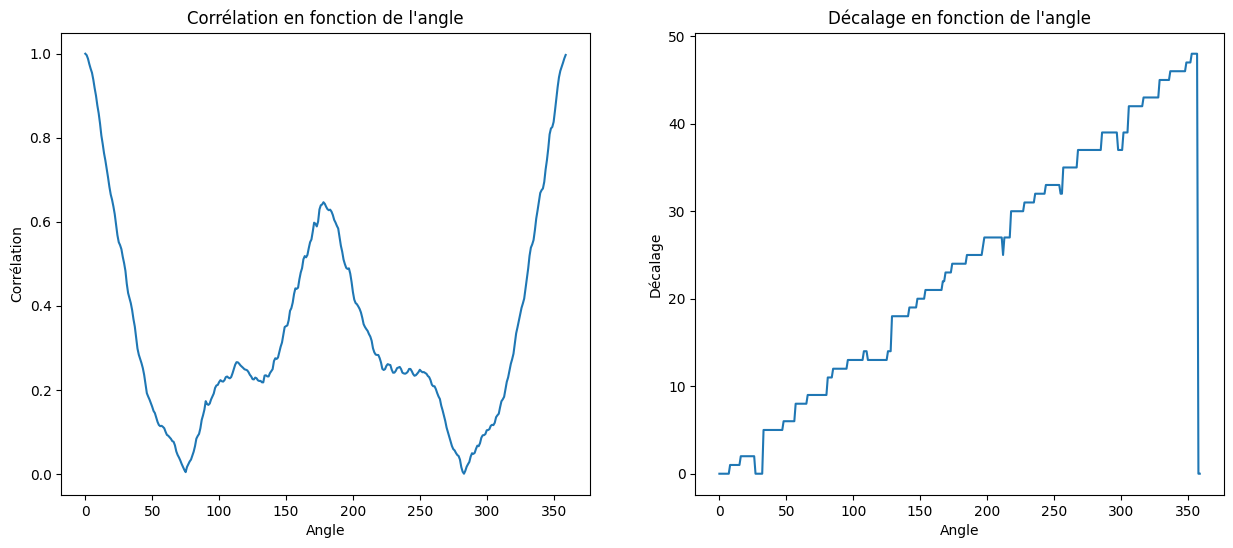

In [57]:
image = random.choice(images)
image_polar, Itheta, Ir = polaire1(image, Nr=50, Mtheta=50, Rmax=50)

def shift_getter(Itheta, Itheta_rotated):
    corr = np.corrcoef(Itheta, Itheta_rotated)[0,1]
    corr = np.abs(corr)
    shift = np.abs(np.argmin(Itheta)-np.argmin(Itheta_rotated))
    return corr, shift


angles = np.arange(0, 360, 1)
C = np.array([])
S = np.array([])
for angle in angles:
    image_rotated = rotate(image, angle)
    image_rotated_polar, Itheta_rotated, Ir_rotated = polaire1(image_rotated)
    corr, shift = shift_getter(Itheta, Itheta_rotated)
    C = np.append(C,corr)
    S = np.append(S,shift)
    
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(angles, C)
plt.title("Corrélation en fonction de l'angle")
plt.xlabel("Angle")
plt.ylabel("Corrélation")
plt.subplot(1,2,2)
plt.plot(angles, S)
plt.title("Décalage en fonction de l'angle")
plt.xlabel("Angle")
plt.ylabel("Décalage")
plt.show()

---

## Partie III - Classification

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Descripteur</h3>

#### Matrice data


In [60]:
def decripteursBDD(path):
    X, y = load_bdd(path)
    print(X.shape)
    vecteur_caracteristique = []
    for i in range(len(X)):
        polar_image, Itheta, Ir = polaire1(X[i])
        vecteur_caracteristique.append([Itheta, Ir])
    return X, vecteur_caracteristique

path = "./images_ISAR"
data, vecteur_caracteristique = decripteursBDD(path)
print("Matrice de données :", data.shape)
print("Vecteur des caractéristiques :", len(vecteur_caracteristique))


(810, 150, 150)
Matrice de données : (810, 150, 150)
Vecteur des caractéristiques : 810




<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Classifieur C1</h3>

In [18]:
def reconnaissance(data):
    n_samples = data.shape[0]
    n_train = int(2/3 * n_samples)  # 2/3 des données pour l'apprentissage
    n_test = n_samples - n_train

    # Base d'apprentissage
    X_train = data[:n_train]
    #y_train = np.arange(n_train)  # Création de vecteur de labels pour la base d'apprentissage
    y_train = label[np.arange(n_train)]
    # Base de test
    X_test = data[n_train:]
    y_test = label[np.arange(n_test) + n_train]
    return X_train, y_train, X_test, y_test

# Utilisation de la fonction reconnaissance
X_train, y_train, X_test, y_test = reconnaissance(data)

# Affichage des tailles des ensembles
print("Taille de la base d'apprentissage :", X_train.shape)
print("Taille vecteur de labels de la base d'apprentissage :", y_train.shape)
print("Taille de la base de test :", X_test.shape)
print("Taille vecteur de labels de la base de test :", y_test.shape)
 

Taille de la base d'apprentissage : (540, 150, 150)
Taille vecteur de labels de la base d'apprentissage : (540,)
Taille de la base de test : (270, 150, 150)
Taille vecteur de labels de la base de test : (270,)


In [58]:
def classifieurC1_Itheta(BA, BT, n_neigh):
    # Extraction de la caractéristique Itheta
    X_train_Itheta = BA[:, 0]  
    X_test_Itheta = BT[:, 0]   
    print(X_train_Itheta.shape)
    print(X_test_Itheta.shape)
    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(X_train_Itheta, y_train)  # Entraînement sur la caractéristique Itheta

    # Prédiction sur la base de test
    y_pred = knn.predict(X_test_Itheta)

    distances, _ = knn.kneighbors(X_test_Itheta, n_neighbors=n_neigh, return_distance=True)  
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100
    return y_pred, accuracy, distances


# Utilisation de la fonction classifieurC1_Ir
k_values = [1, 3, 5]
for k in k_values:
    y_pred_test, taux, distances = classifieurC1_Itheta(X_train, X_test, n_neigh=k)

    # Affichage des prédictions et du taux de classification
    print(f"> Taux de classification pour k={k}: {taux:.4f}%")
    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"    - Matrice de distances pour k={k} (premier échantillon de la base de test) :\n {distances[0]}")






(540, 150)
(270, 150)
> Taux de classification pour k=1: 100.0000%
    - Matrice de distances pour k=1 (premier échantillon de la base de test) :
 [5.19615242]
(540, 150)
(270, 150)
> Taux de classification pour k=3: 100.0000%
    - Matrice de distances pour k=3 (premier échantillon de la base de test) :
 [5.19615242 6.70820393 8.60232527]
(540, 150)
(270, 150)
> Taux de classification pour k=5: 97.0370%
    - Matrice de distances pour k=5 (premier échantillon de la base de test) :
 [5.19615242 6.70820393 8.60232527 8.66025404 8.88819442]


In [59]:
def classifieurC1_II(BA,BT,n_neigh):
    X_train_Ir = BA[:, 1]
    X_test_Ir = BT[:, 1] 

    # Création du classifieur KNN
    knn = KNeighborsClassifier(n_neighbors=n_neigh)
    knn.fit(X_train_Ir, y_train)  # Entraînement sur la caractéristique Itheta

    # Prédiction sur la base de test
    y_pred = knn.predict(X_test_Ir)

    distances, indices = knn.kneighbors(X_test_Ir, n_neighbors=n_neigh, return_distance=True)  
    
    accuracy = sk.metrics.accuracy_score(y_test, y_pred) * 100
    return y_pred, accuracy, distances


# Utilisation de la fonction classifieurC1_Ir
k_values = [1, 3, 5]
for k in k_values:
    y_pred_test, taux, distances = classifieurC1_Itheta(X_train, X_test, n_neigh=k)

    # Affichage des prédictions et du taux de classification
    print(f"> Taux de classification pour k={k}: {taux:.4f}%")

    # Affichage de la matrice de distances pour le premier échantillon de la base de test
    print(f"    - Matrice de distances pour k={k} (premier échantillon de la base de test) :\n {distances[0]}")







(540, 150)
(270, 150)
> Taux de classification pour k=1: 100.0000%
    - Matrice de distances pour k=1 (premier échantillon de la base de test) :
 [5.19615242]
(540, 150)
(270, 150)
> Taux de classification pour k=3: 100.0000%
    - Matrice de distances pour k=3 (premier échantillon de la base de test) :
 [5.19615242 6.70820393 8.60232527]
(540, 150)
(270, 150)
> Taux de classification pour k=5: 97.0370%
    - Matrice de distances pour k=5 (premier échantillon de la base de test) :
 [5.19615242 6.70820393 8.60232527 8.66025404 8.88819442]


<div class="alert alert-info">
<h3 class="alert-heading"> Question 5 - Classifieur C2 </h3>

<div class="alert alert-info">
<h3 class="alert-heading"> Question 6 - Rotation et changement d'échelle </h3>